In [10]:
%matplotlib inline

## [Kernel Approximation Transforms](https://scikit-learn.org/stable/modules/kernel_approximation.html)
- These functions approximate kernels for feature mapping. They perform non-linear transforms.
- Explicit mappings are better suited for online learning & can reduce the cost of learning very large datasets.
- Standard kernelized SVMs do not scale well - an approximate kernel map enables you to use more efficient linear SVMs.

## [Nystroem Method](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem)
- A general method of low-rank kernel approximation. It subsamples the data used for kernel evaluation.
- Nystroem uses an ```rbf``` kernel by default but can use any kernel function or predefined kernel matrix.
- The number of samples used is given by ```n_components'''.

In [11]:
from sklearn.kernel_approximation import Nystroem
from sklearn import datasets
from sklearn import svm

X, y = datasets.load_digits(n_class=9, return_X_y=True)
data = X / 16.
clf = svm.LinearSVC()

feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=300)

data_transformed = feature_map_nystroem.fit_transform(data)
clf.fit(data_transformed, y)

clf.score(data_transformed, y)

0.9987631416202845

## [RBF Kernel Sampler](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html#sklearn.kernel_approximation.RBFSampler)
- Builds an approximate map for the RBF kernel.
- It uses a Monte Carlo approximation to the kernel values.
- ```n_components``` is the target dimensionality of the feature transform; ```gamma``` is the RBF kernel parameter. Higher ```n_components``` returns a better kernel approximation.
- RBF Sampler is usually less accurate than Nystroem. It is easier to compute, thus making the use of large feature spaces more efficient.

## Example: [RBF Kernel Sampler](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py)
- Shows how to use RBF Sampler & Nystroem to approximate the feature map of an RBF kernel for SVM-based classification on the digits dataset.
- Compares results from a linear SVM (original space), linear SVM (approx mappings) and a kernelized SVM.
- Note: the dataset is not large enough to really show the benefits of kernel approximation - the exact SVM is still reasonably fast.
- Sampling more dimensions leads to better classification results but at a greater processing cost.

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import (RBFSampler, Nystroem)
from sklearn.decomposition import PCA

digits = datasets.load_digits(n_class=9)

In [13]:
n_samples = len(digits.data)
data      = digits.data / 16.
data     -= data.mean(axis=0)

# learn the digits on the first half of the digits
data_train, targets_train = (data[:n_samples // 2],
                             digits.target[:n_samples // 2])


# predict digits on the second half:
data_test, targets_test = (data[n_samples // 2:],
                           digits.target[n_samples // 2:])

# data_test = scaler.transform(data_test)

# Create a classifier: a support vector classifier
kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()

# create pipeline from kernel approximation & linear svm
feature_map_fourier  = RBFSampler(gamma=.2, 
                                  random_state=1)
feature_map_nystroem = Nystroem(gamma=.2, 
                                random_state=1)
fourier_approx_svm = pipeline.Pipeline([("feature_map", 
                                         feature_map_fourier),
                                        ("svm", 
                                         svm.LinearSVC())])

nystroem_approx_svm = pipeline.Pipeline([("feature_map", 
                                          feature_map_nystroem),
                                        ("svm", 
                                         svm.LinearSVC())])


kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

In [14]:
for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, 
                                             targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, 
                                               targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

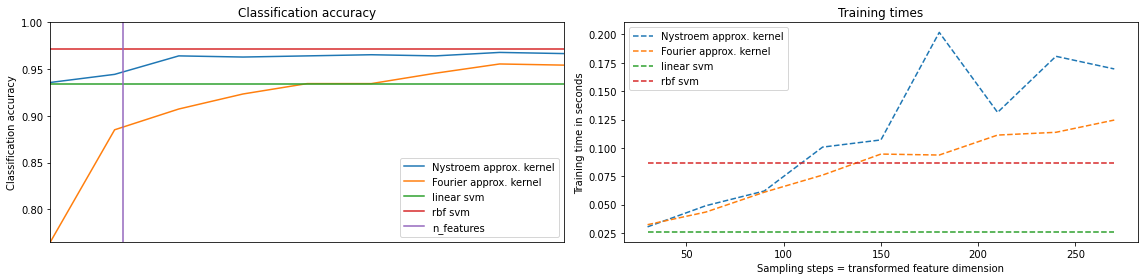

In [15]:
# plot the results:
plt.figure(figsize=(16, 4))
accuracy = plt.subplot(121)
# second y axis for timings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, 
              nystroem_scores, 
              label="Nystroem approx. kernel")

timescale.plot(sample_sizes, 
               nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, 
              fourier_scores, 
              label="Fourier approx. kernel")

timescale.plot(sample_sizes, 
               fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], 
               sample_sizes[-1]],
              [linear_svm_score, 
               linear_svm_score], 
              label="linear svm")

timescale.plot([sample_sizes[0], 
                sample_sizes[-1]],
               [linear_svm_time,
                linear_svm_time], '--', 
               label='linear svm')

accuracy.plot([sample_sizes[0], 
               sample_sizes[-1]],
              [kernel_svm_score, 
               kernel_svm_score], 
              label="rbf svm")

timescale.plot([sample_sizes[0], 
                sample_sizes[-1]],
               [kernel_svm_time, 
                kernel_svm_time], '--', 
               label='rbf svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], 
              label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
accuracy.set_ylabel("Classification accuracy")
accuracy.legend(loc='best')

timescale.set_title("Training times")
timescale.set_xlabel("Sampling steps = transformed feature dimension")
timescale.set_ylabel("Training time in seconds")
timescale.legend(loc='best')

plt.tight_layout()
plt.show()

## [Decision Surfaces: RBF Kernel SVM, Linear SVM](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#decision-surfaces-of-rbf-kernel-svm-and-linear-svm)
- Show classifier decision surfaces projected on 1st two principal components.

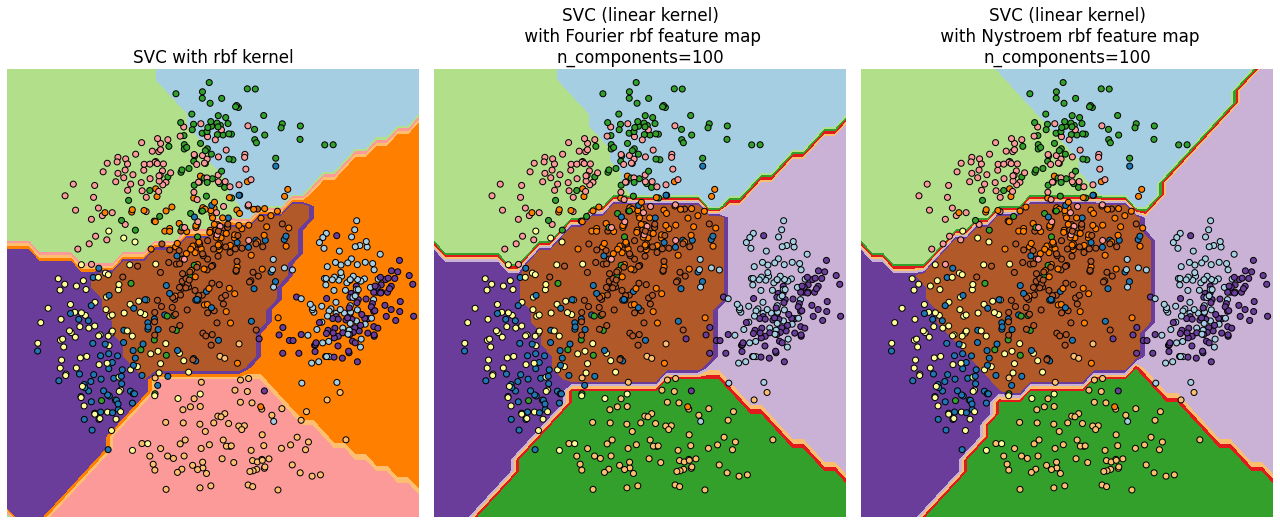

In [16]:
pca = PCA(n_components=8).fit(data_train)

X = pca.transform(data_train)

multiples = np.arange(-2, 2, 0.1)
first     = multiples[:, np.newaxis] * pca.components_[0, :]
second    = multiples[:, np.newaxis] * pca.components_[1, :]
grid      = first[np.newaxis, :, :] + second[:, np.newaxis, :]
flat_grid = grid.reshape(-1, data.shape[1])

titles = ['SVC with rbf kernel',
          'SVC (linear kernel)\n with Fourier rbf feature map\n'
          'n_components=100',
          'SVC (linear kernel)\n with Nystroem rbf feature map\n'
          'n_components=100']

plt.figure(figsize=(18, 7.5))
plt.rcParams.update({'font.size': 14})

for i, clf in enumerate((kernel_svm, 
                         nystroem_approx_svm,
                         fourier_approx_svm)):
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples, multiples, Z, cmap=plt.cm.Paired)
    plt.axis('off')
    plt.scatter(X[:, 0], 
                X[:, 1], 
                c=targets_train, 
                cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))

    plt.title(titles[i])
plt.tight_layout()
plt.show()


## [Additive Chi-Squared Kernel](https://scikit-learn.org/stable/modules/kernel_approximation.html#additive-chi-squared-kernel)
- Histogram kernel - often used in computer vision.
- Defined as $k(x, y) = \sum_i \frac{2x_iy_i}{x_i+y_i}$
- Not the same as the ```additive_chi2_kernel``` metric function.
- Each component is sampled _n_ times yielding _2n+1_ dimensions per input dimension.

In [17]:
from sklearn.datasets             import load_digits
from sklearn.linear_model         import SGDClassifier
from sklearn.kernel_approximation import AdditiveChi2Sampler

X, y          = load_digits(return_X_y=True)
chi2sampler   = AdditiveChi2Sampler(sample_steps=2)
X_transformed = chi2sampler.fit_transform(X, y)

clf = SGDClassifier(max_iter=500, 
                    random_state=0, 
                    tol=1e-3)
clf.fit(X_transformed, y)
clf.score(X_transformed, y)

0.9821925431274346

## [Skewed Chi-Squared Kernel](https://scikit-learn.org/stable/modules/kernel_approximation.html#skewed-chi-squared-kernel)
- Defined as $k(x,y) = \prod_i \frac{2\sqrt{x_i+c}\sqrt{y_i+c}}{x_i + y_i + 2c}$

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import SkewedChi2Sampler

X = [[0, 0], [1, 1], [1, 0], [0, 1]]
y = [0, 0, 1, 1]

chi2_feature = SkewedChi2Sampler(skewedness=.01,
                                 n_components=10,
                                 random_state=0)

X_features = chi2_feature.fit_transform(X, y)
clf = SGDClassifier(max_iter=10, tol=1e-3)

clf.fit(X_features, y)
clf.score(X_features, y)

1.0